## TPS July 2022

- Inspired by https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting/notebook, following notebook is to demonstrate different classifiers with Soft voting using only using Sklearn
- Thank you everyone for great ideas (Apology if i did not add anyone specifically)

In [1]:
import pandas as pd
import numpy as np

import gc,random,os

from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier

from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set Static variables
random_state = 2
#n_folds = 10
n_components = 7
verbose = 500
os.environ['PYTHONHASHSEED'] = str(random_state)
np.random.seed(random_state)

In [3]:
# Read training data
data = pd.read_csv("../input/tabular-playground-series-jul-2022/data.csv",index_col = 'id')
sample_submission =pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

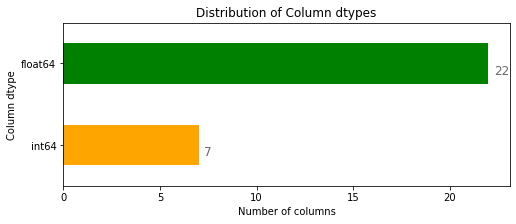

In [4]:
ax = data.dtypes.value_counts().plot.barh(color = ['green','orange'],rot = 0,figsize = (8,3))
ax.set_title('Distribution of Column dtypes')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Column dtype')

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()), fontsize=12,
color='dimgrey')
    
ax.invert_yaxis()

In [5]:
# Using PowerTransformer before Scaling to adjust for Outliers
data_scaled = pd.DataFrame(PowerTransformer().fit_transform(data),columns=data.columns)
data_scaled = pd.DataFrame(RobustScaler().fit_transform(data_scaled), columns=data_scaled.columns)

#www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/334808
useful_cols  = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

# Test Data for predictions later
test_data = data_scaled[useful_cols].copy()

In [6]:
# Fit Bayesian Gaussian Mixture
print('Fitting Bayesian Gaussian Mixture..')
bgm = BayesianGaussianMixture(n_components = n_components,
                         max_iter = 300, n_init = 10, 
                     random_state = random_state,
                 verbose = 1,
             verbose_interval = 100
                     )

bgm_labels = bgm.fit_predict(data_scaled[useful_cols])
bgm_proba = bgm.predict_proba(data_scaled[useful_cols])

Fitting Bayesian Gaussian Mixture..
Initialization 0
  Iteration 100
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
  Iteration 100
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
Initialization 5
  Iteration 100
Initialization converged: True
Initialization 6
  Iteration 100
Initialization converged: True
Initialization 7
  Iteration 100
Initialization converged: True
Initialization 8
  Iteration 100
Initialization converged: True
Initialization 9
Initialization converged: True


In [7]:
#Using idea from https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting

# Creating Best data based on predicted probability of BGM model

data_scaled['predict']= bgm_labels
data_scaled['predict_proba']=0

for n in range(n_components):
    data_scaled[f'bgm_proba_{n}']= bgm_proba[:,n]
    data_scaled.loc[data_scaled.predict == n,'bgm_proba']=data_scaled[f'bgm_proba_{n}']
    
train_index=np.array([])
for n in range(n_components):
    median=data_scaled[data_scaled.predict==n]['bgm_proba'].median()

    # Experiment with different thresholds
    # Higher thereshold might overfit
    n_inx=data_scaled[(data_scaled.predict==n) & (data_scaled.bgm_proba > 0.8)].index
    
    train_index = np.concatenate((train_index, n_inx))
    print(f'class:{n}',f'median: {round(median,4)}','Training data:'+str(round(len(n_inx)/len(data_scaled[(data_scaled.predict==n)]),2)*100)+'%')
    
    
print(f'\nSize of Training data : {len(train_index)}')

class:0 median: 0.8669 Training data:60.0%
class:1 median: 0.9118 Training data:65.0%
class:2 median: 0.9833 Training data:82.0%
class:3 median: 0.8684 Training data:60.0%
class:4 median: 0.9376 Training data:70.0%
class:5 median: 0.9073 Training data:67.0%
class:6 median: 0.7315 Training data:40.0%

Size of Training data : 62516


In [8]:
X=data_scaled.loc[train_index][useful_cols]
y=data_scaled.loc[train_index]['predict']

#xtrain,xvalid, ytrain,yvalid = train_test_split(X,y,random_state = random_state,test_size = 0.2)

In [9]:
# XG Boost can also be used
gbc = GradientBoostingClassifier(n_estimators = 5000,
                        subsample = 0.6,
                        random_state=random_state,
                     max_features = 'auto',
                    validation_fraction =0.2,
                    n_iter_no_change = 300,
                    )

# This is inspired by LGBM. LGBM can also be used directly
hgbc = HistGradientBoostingClassifier(max_iter = 5000,
                                      learning_rate = 0.06,
                                      random_state=random_state,
                    validation_fraction =0.2,
                    n_iter_no_change = 300,
                    l2_regularization=0.1,
)

# Saving time by using ML classifier. Can experiment with Torch/Keras based NN models as well
mlpc = MLPClassifier(learning_rate = 'adaptive',
                    max_iter = 5000,
                    hidden_layer_sizes = (400,200,100,),
                    early_stopping = True,
                    n_iter_no_change = 200,
                    validation_fraction = 0.2,
                    )

# This is simplified version of soft voting as suggested by 
# https://www.kaggle.com/code/pourchot/simple-soft-voting?scriptVersionId=100462375&cellId=6
vcsft = VotingClassifier(estimators=[('GBC', gbc), ('HGBC', hgbc),('MLPC',mlpc)], 
                 voting='soft',verbose=verbose)

In [10]:
vcsft.fit(X,y)

[Voting] ...................... (1 of 3) Processing GBC, total=28.5min
[Voting] ..................... (2 of 3) Processing HGBC, total= 4.7min
[Voting] ..................... (3 of 3) Processing MLPC, total=17.9min


VotingClassifier(estimators=[('GBC',
                              GradientBoostingClassifier(max_features='auto',
                                                         n_estimators=5000,
                                                         n_iter_no_change=300,
                                                         random_state=2,
                                                         subsample=0.6,
                                                         validation_fraction=0.2)),
                             ('HGBC',
                              HistGradientBoostingClassifier(l2_regularization=0.1,
                                                             learning_rate=0.06,
                                                             max_iter=5000,
                                                             n_iter_no_change=300,
                                                             random_state=2,
                                                             v

In [11]:
Predicted = vcsft.predict(test_data)

In [12]:
sample_submission['Predicted']= Predicted
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,2
4,4,3


- This submission has LB score of 0.61428

#### Future thoughts for experiment:
- Different combinations of soft voting : Adding Linear Discriminant Analysis, Gaussian Naive Bias for analysis as well
- Use lower threshold for preparing classification data
- Tune Hyperparameter for each model before Soft Voting
- Train with different seed (we have observed change in score with different threshholds)
- Use Cross validation